In [4]:
library(ggplot2)
library(tidyverse)
library(gridExtra) 
library(viridis)
library(cowplot)
library(reshape2)

In [5]:
epi_clusters <- read.csv('../data/epi_average24_PTCODE.csv')[,-1]

In [6]:
transm_clus <- epi_clusters %>% filter(average24.x == average24.y) %>% 
group_by(average24.x, transm) %>% 
tally() %>% 
filter(transm=='Yes') %>% 
select(average24.x)
dim(transm_clus)

all_clus <- epi_clusters %>% filter(average24.x == average24.y) %>% 
group_by(average24.x, transm) %>% 
tally() %>% 
# filter(transm=='Yes') %>% 
select(average24.x)
dim(all_clus)

mt2_clusters <-  epi_clusters %>% filter(average24.x == average24.y) %>% 
group_by(average24.x) %>% 
tally() %>% filter(n>1)
dim(mt2_clusters)

df2_complete_room <- epi_clusters %>%
  filter(!is.na(nRoom.x) & !is.na(nRoom.y)) %>%
filter(SequenceType.x == SequenceType.y)

[1] 82  1

[1] 335   1

[1] 183   2

In [7]:
### Source for each cluster

## Clus Source all cluster
clus_source_all <- rbind(epi_clusters %>% filter(average24.x == average24.y) %>% 
filter(average24.x %in% all_clus$average24.x) %>%
select(Sample.1	, average24.x, Source.x) %>%
rename(Sample='Sample.1', Cluster='average24.x',Source = 'Source.x'),

epi_clusters %>% filter(average24.x	== average24.y) %>% 
filter(average24.x %in% all_clus$average24.x) %>%
select(Sample.2	, average24.y,Source.y) %>%
rename(Sample='Sample.2', Cluster='average24.y', Source = 'Source.y')) %>%
distinct()

In [8]:
clus_source_pat <-  rbind(epi_clusters %>% filter(average24.x == average24.y) %>% 
filter(average24.x %in% all_clus$average24.x) %>%
select(Sample.1	, average24.x, Source.x,Patient.x,HOSP.x,nRoom.x,Date.of.Collection.x,SourceEnv.x,PTCOEX_base.x,PTCOEX_suffix.x,ad_swab.x,ICU_HCI.x) %>%
rename(Sample='Sample.1', Cluster='average24.x',Source = 'Source.x', Patient='Patient.x',H='HOSP.x',Room='nRoom.x',
       Collection='Date.of.Collection.x',Source2='SourceEnv.x',PTCOEX_base='PTCOEX_base.x',PTCOEX_suffix='PTCOEX_suffix.x',ad_swab='ad_swab.x',ICU_HCI='ICU_HCI.x'),

epi_clusters %>% filter(average24.x	== average24.y) %>% 
filter(average24.x %in% all_clus$average24.x) %>%
select(Sample.2	, average24.y, Source.y,Patient.y,HOSP.y,nRoom.y,Date.of.Collection.y,SourceEnv.y,PTCOEX_base.y,PTCOEX_suffix.y,ad_swab.y,ICU_HCI.y) %>%
rename(Sample='Sample.2', Cluster='average24.y',Source = 'Source.y', Patient='Patient.y',H='HOSP.y',Room='nRoom.y',
       Collection='Date.of.Collection.y',Source2='SourceEnv.y',PTCOEX_base='PTCOEX_base.y',PTCOEX_suffix='PTCOEX_suffix.y',ad_swab='ad_swab.y',ICU_HCI='ICU_HCI.y')) %>%
distinct()

In [9]:
clus_source_pat <- clus_source_pat %>%
  mutate(pat_id = coalesce(PTCOEX_base, Patient))

In [10]:
## Number of clusters and Sources

cluster_source_summary <- clus_source_pat %>%
  group_by(Cluster) %>%
  summarise(
    sources = paste(sort(unique(Source)), collapse = ",")
  ) %>%
  mutate(
    cluster_type = case_when(
      sources == "Clinical" ~ "Only Clinical",
      sources == "Environmental" ~ "Only Environmental",
      TRUE ~ "Both"
    )
  ) %>%
  count(cluster_type, name = "n_clusters")
cluster_source_summary

cluster_type,n_clusters
<chr>,<int>
Both,31
Only Clinical,150
Only Environmental,95


In [11]:

# Step 1: Classify clusters by source type
cluster_types <- clus_source_pat %>%
  group_by(Cluster) %>%
  summarise(
    sources = paste(sort(unique(Source)), collapse = ",")
  ) %>%
  mutate(
    cluster_type = case_when(
      sources == "Clinical" ~ "Only Clinical",
      sources == "Environmental" ~ "Only Environmental",
      TRUE ~ "Both"
    )
  )

# Step 2: Filter original df for "Only Clinical" clusters and count unique pat_id per cluster
clinical_clusters_multiple_patid <- clus_source_pat %>%
  left_join(cluster_types, by = "Cluster") %>%
  filter(cluster_type == "Only Clinical") %>%
  group_by(Cluster) %>%
  summarise(n_pat_ids = n_distinct(pat_id)) %>%
  filter(n_pat_ids > 1) %>%
  nrow()


# Step 1: Identify the relevant clusters
clinical_clusters_with_multiple_patids <- clus_source_pat %>%
  left_join(cluster_types, by = "Cluster") %>%
  filter(cluster_type == "Only Clinical") %>%
  group_by(Cluster) %>%
  summarise(n_pat_ids = n_distinct(pat_id)) %>%
  filter(n_pat_ids > 1)
dim(clinical_clusters_with_multiple_patids)

# Step 2: Count the number of samples in those clusters
n_samples_in_those_clusters <- clus_source_pat %>%
  filter(Cluster %in% clinical_clusters_with_multiple_patids$Cluster) %>%
  nrow()

n_samples_in_those_clusters

[1] 46  2

[1] 233

In [12]:
clusters_multiple_H <- clus_source_pat %>%
  group_by(Cluster) %>%
  summarise(n_H = n_distinct(H)) %>%
  filter(n_H >  1) %>%
  nrow()

clusters_multiple_H

[1] 38

In [13]:
sample_counts_per_cluster_type <- clus_source_pat %>%
  left_join(cluster_types %>% select(Cluster, cluster_type), by = "Cluster") %>%
  count(cluster_type, name = "n_samples")

sample_counts_per_cluster_type

cluster_type,n_samples
<chr>,<int>
Both,483
Only Clinical,566
Only Environmental,773


In [14]:
# Filter to relevant cluster types and ICU_HCI samples, then count unique clusters
clusters_with_ICU_HCI <- clus_source_pat %>%
  left_join(cluster_types, by = "Cluster") %>%
  filter(cluster_type %in% c("Both", "Only Clinical"), ICU_HCI == 1) %>%
  distinct(Cluster, cluster_type) %>%
  count(cluster_type, name = "n_clusters_with_ICU_HCI")

clusters_with_ICU_HCI

cluster_type,n_clusters_with_ICU_HCI
<chr>,<int>
Both,8
Only Clinical,26


In [16]:
# Step 2: Check how many of those clusters have any ICU_HCI == 1 sample
n_clusters_with_ICU <- clus_source_pat %>%
  filter(Cluster %in% clinical_clusters_with_multiple_patids$Cluster,
         ICU_HCI == 1) %>%
  distinct(Cluster) %>%
  nrow()

n_clusters_with_ICU

# Step 1: Get "Both" clusters with multiple pat_ids
both_clusters_with_multiple_patids <- clus_source_pat %>%
  left_join(cluster_types, by = "Cluster") %>%
  filter(cluster_type == "Both") %>%
  group_by(Cluster) %>%
  summarise(n_pat_ids = n_distinct(pat_id)) %>%
  filter(n_pat_ids > 1)

# Step 2: Check how many of those clusters have at least one ICU sample
n_both_clusters_with_ICU <- clus_source_pat %>%
  filter(Cluster %in% both_clusters_with_multiple_patids$Cluster,
         ICU_HCI == 1) %>%
  distinct(Cluster) %>%
  nrow()

n_both_clusters_with_ICU

[1] 11

[1] 8

In [17]:
library(lubridate)

# Ensure Collection is Date type
clus_source_pat <- clus_source_pat %>%
  mutate(Collection = as.Date(Collection))

# Step 1: Identify clusters with both Clinical and Environmental sources
both_clusters <- cluster_types %>%
  filter(cluster_type == "Both") %>%
  pull(Cluster)

# Step 2: Subset data to those clusters only
df_both_clusters <- clus_source_pat %>%
  filter(Cluster %in% both_clusters)

# Step 3: Get first isolate per pat_id in those clusters
first_isolates <- df_both_clusters %>%
  arrange(pat_id, Collection) %>%
  group_by(pat_id) %>%
  slice(1) %>%
  ungroup()

# Step 4: Count how many first isolates are Environmental
n_env_first_isolates <- first_isolates %>%
  filter(Source == "Environmental") %>%
  nrow()

n_env_first_isolates

[1] 1

In [18]:
# filter only transmission cluster 

transm_clus <- clus_source_pat %>% filter(Cluster %in% (c(clinical_clusters_with_multiple_patids$Cluster,
both_clusters)))

transm_clus <- transm_clus  %>%
  mutate(positive_on_admission = if_else(!is.na(ad_swab), "yes", NA)) 

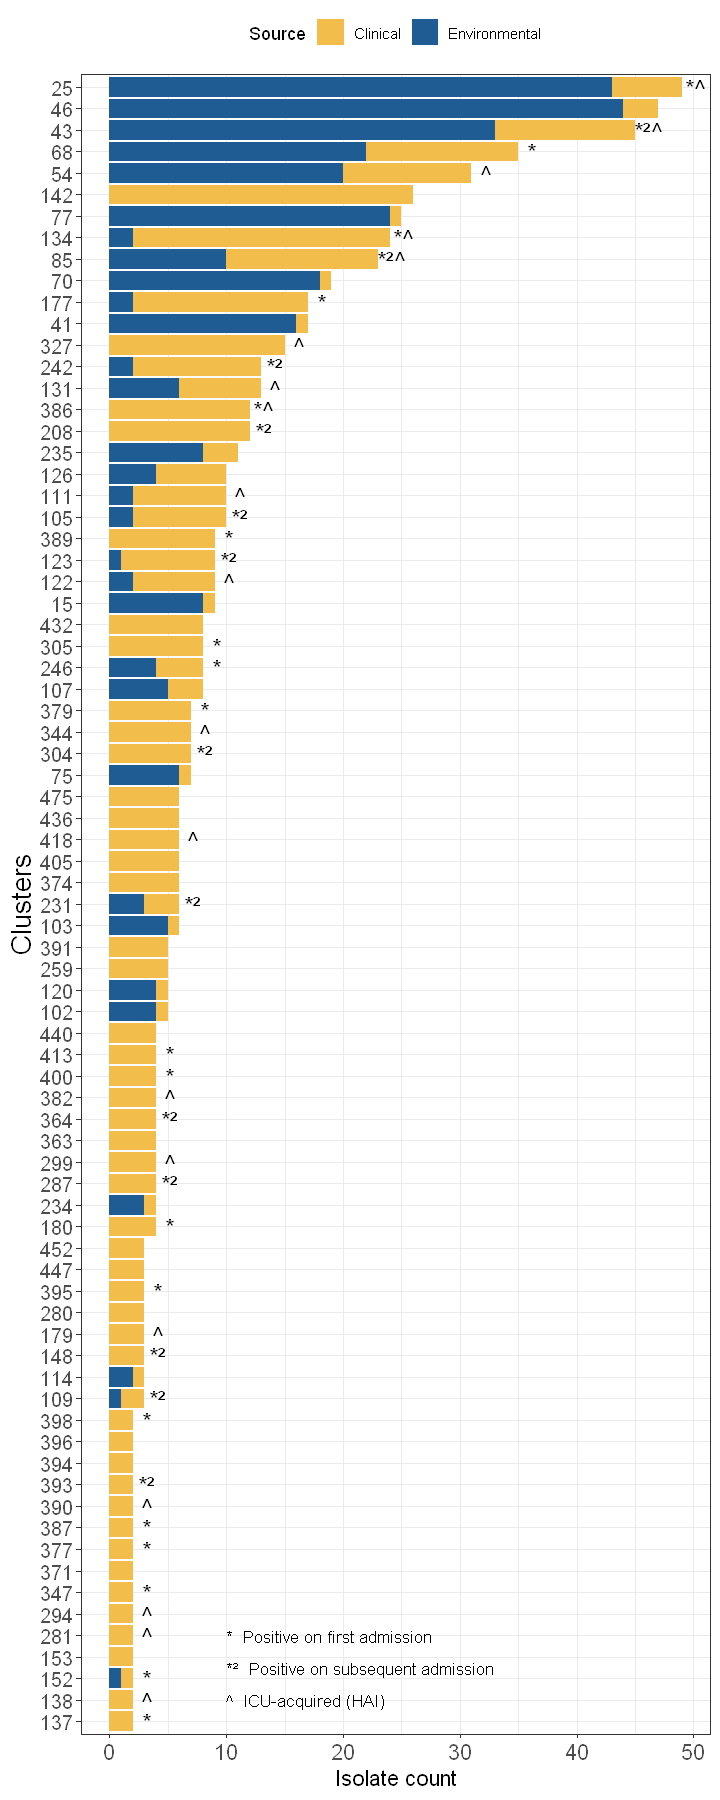

In [19]:
### PLOT ###
############

options(repr.plot.width = 6, repr.plot.height = 15)


# Step 1: Get total size per cluster (regardless of source)
cluster_order <- transm_clus %>%
  group_by(Cluster) %>%
  summarise(total_n = n(), .groups = "drop")

# Step 2: Prepare bar_data with flags and left join for ordering
bar_data <- transm_clus %>%
  group_by(Cluster, Source) %>%
 summarise(
    count = n(),
    has_admission = any(positive_on_admission == "yes", na.rm = TRUE),
    has_hci = any(ICU_HCI == 1, na.rm = TRUE),
    poa_first = any(positive_on_admission == "yes" & PTCOEX_suffix == "0", na.rm = TRUE),
    poa_subseq = any(positive_on_admission == "yes" & PTCOEX_suffix != "0", na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(cluster_order, by = "Cluster") %>%
  mutate(
    annotation = case_when(
      poa_first & has_hci ~ "*^",
      poa_subseq & has_hci ~ "*²^",
      poa_first ~ "*",
      poa_subseq ~ "*²",
      has_hci ~ "^",
      TRUE ~ ""
    ),
    Cluster_fct = fct_reorder(as.factor(Cluster), total_n)
  )

# Step 3: Plot
source_plot <- ggplot(bar_data, aes(y = Cluster_fct, x = count, fill = Source)) +
  geom_bar(stat = "identity") +
  geom_text(aes(x = total_n + 1.2, label = annotation), size = 5) +  # explicit position
  annotate("text", x =10, y = 5, label = "*  Positive on first admission", hjust = 0, size = 3.5) +
  annotate("text", x =10, y = 3.5, label = "*²  Positive on subsequent admission", hjust = 0, size = 3.5) +
  annotate("text", x =10, y = 2, label = "^  ICU-acquired (HAI)", hjust = 0, size = 3.5) +
  labs(x = "Isolate count", y = "Clusters") +
  scale_fill_manual(values = c('#F3BD4C', '#1F5C93'), name = 'Source') +
  theme_bw() +
  theme(
    legend.position = 'top',
    axis.text.y = element_text(size = 12),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 13),
    axis.title.x = element_text(size = 13)
  ) +
  coord_cartesian(xlim = c(0, max(bar_data$count) + 5))
source_plot

source_legend <- get_legend(source_plot)

In [20]:
### Epi Score PLOT ####


score_cat_colors <- c('High'='#771427','Med'='#AA5C39','Low'='#D4A56A','Not-linked'='#D4CC6A',
                      'Same Patient'='#672770','Same Room'='#457585', 'NA'='grey')

transm77 <- transm_clus %>% select(Cluster) %>% distinct()


clus_score <- epi_clusters %>% 
filter(average24.x %in% transm77$Cluster) %>% 
filter(average24.y %in% transm77$Cluster) %>% 
filter(average24.x == average24.y)%>%
select(Sample.1,Sample.2, score_cat,average24.x)%>%
rename(Clusters = 'average24.x')

clus_score_n <- clus_score %>% group_by(Clusters) %>%
tally()

clus_score_ord  <- merge(clus_score,clus_score_n, by='Clusters' )
clus_score_ord$Clusters <- as.factor(clus_score_ord$Clusters)
# clus_score_ord

clus_score_ord <- clus_score_ord %>% 
mutate(score_cat = case_when(score_cat == 'same_room_env' ~ 'Same Room',
                            TRUE ~ score_cat)) %>% 
mutate(score_cat = case_when(score_cat == 'Same_Patient' ~ 'Same Patient',
                            TRUE ~ score_cat))

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


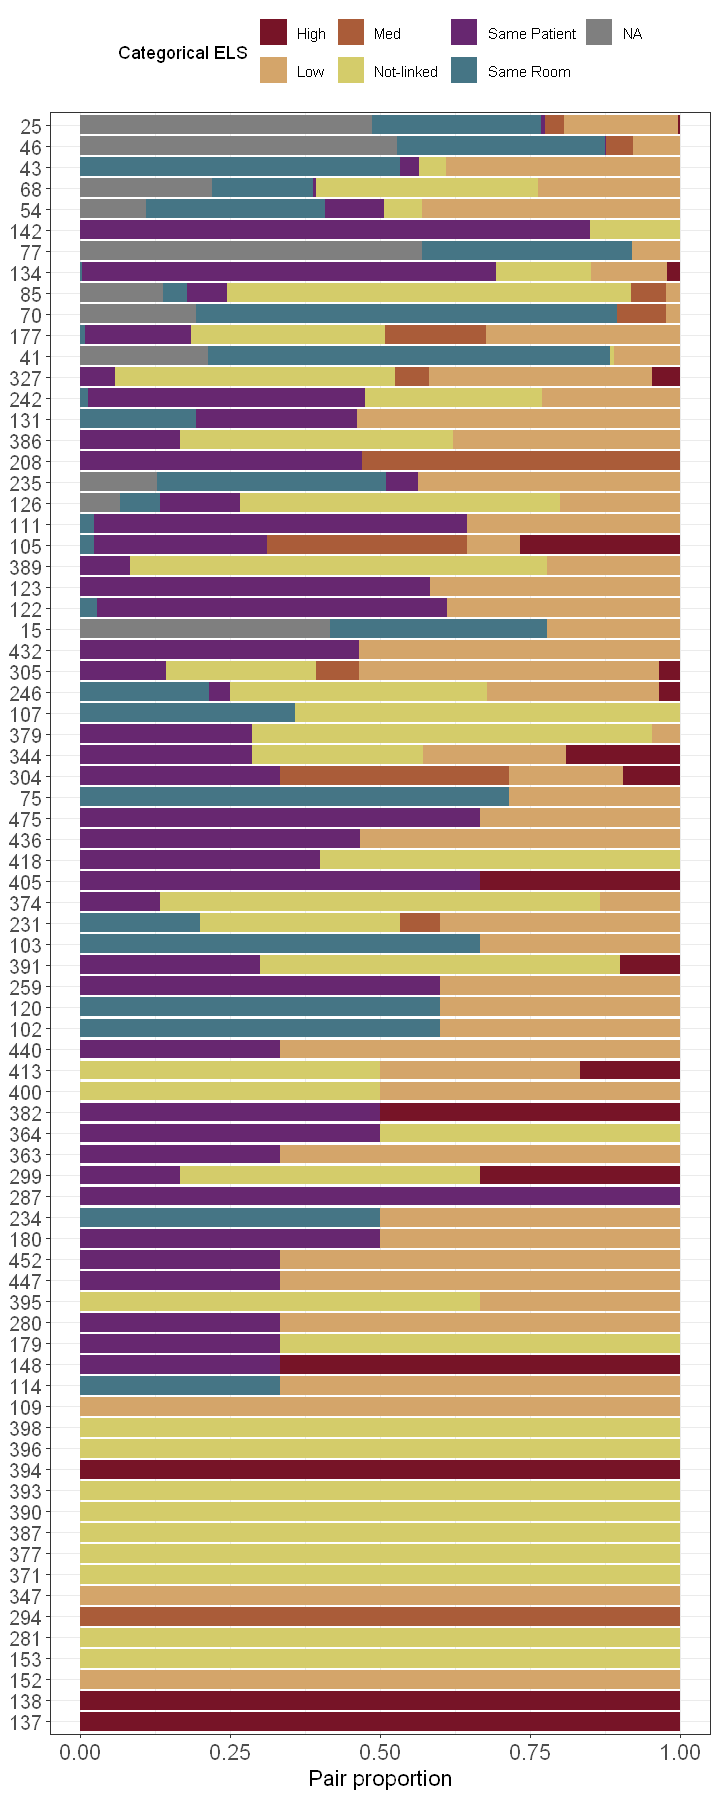

In [21]:
score_plot <- clus_score_ord %>% ggplot()+
aes(y= fct_reorder(Clusters,n), fill=score_cat)+
geom_bar(stat = 'count')+
scale_fill_manual(values=score_cat_colors, name='Categorical ELS')+
theme_bw()+
labs(x='Pair count')+
theme(legend.position = 'top',
      axis.text.y = element_text(size=11),
     axis.title.y = element_blank(),
      axis.text.x = element_text(size=11),
     axis.title.x = element_text(size=13))
score_legend <- get_legend(score_plot)
# score_plot

clus_score_ord_prop <- clus_score_ord %>% group_by(Clusters,score_cat,n) %>%
tally() %>% mutate(prop=nn/n)

score_prop_plot <- clus_score_ord_prop %>% ggplot()+
aes(y= fct_reorder(Clusters,n),x=prop, fill=score_cat)+
geom_bar(stat = 'identity')+
scale_fill_manual(values=score_cat_colors, name='Categorical ELS')+
theme_bw()+
labs(x='Pair proportion')+
theme(legend.position = 'top',
      axis.text.y = element_text(size=12),
     axis.title.y = element_blank(),
      axis.text.x = element_text(size=13),
     axis.title.x = element_text(size=13))
score_prop_plot

score_legend <- get_legend(score_prop_plot)

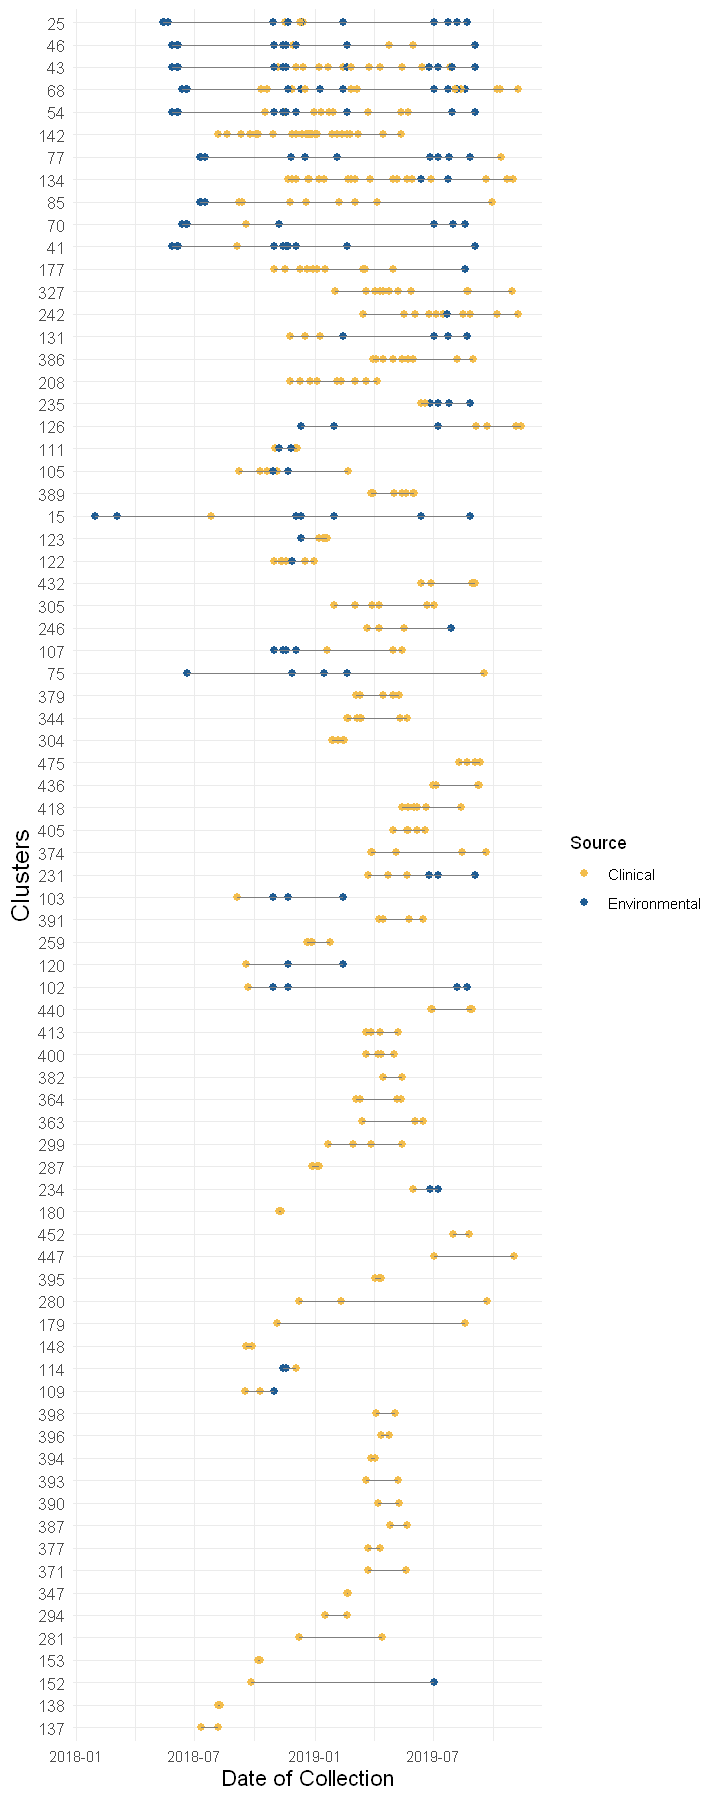

In [23]:
## Date of collection plot ###

# Reshape to long format
long_data <- epi_clusters %>% 
filter(average24.x %in% transm77$Cluster) %>% 
filter(average24.y %in% transm77$Cluster) %>% 
filter(average24.x == average24.y) %>%
  select(Sample.1, Sample.2, average24.x, Date.of.Collection.x, Date.of.Collection.y, Source.x, Source.y) %>%
  pivot_longer(
    cols = c(Sample.1, Sample.2),
    names_to = "Sample_role",
    values_to = "Sample"
  ) %>%
  mutate(
    Date = case_when(
      Sample_role == "Sample.1" ~ Date.of.Collection.x,
      Sample_role == "Sample.2" ~ Date.of.Collection.y
    ),
    Source = case_when(
      Sample_role == "Sample.1" ~ Source.x,
      Sample_role == "Sample.2" ~ Source.y
    )
  ) %>%
  select(Sample, Date, Source, average24.x) %>%
  distinct()

sorted_clusters <- long_data %>% select(Sample,average24.x) %>% group_by(average24.x) %>% tally() %>% arrange(desc(n))
long_data <- merge(long_data, sorted_clusters, by = 'average24.x', all.x=TRUE)

long_data$average24.x <- as.factor(as.character(long_data$average24.x))

# as.factor(as.character(long_data$n))

line_plot <- ggplot(long_data, aes(x = as.Date(Date), y = reorder(average24.x,n), color = Source)) +
  geom_point(size = 2) +
  geom_line(aes(group = average24.x), color = "gray50", linewidth = 0.3) +
  labs(x = "Date of Collection", y = "Clusters") +
  scale_color_manual(values = c('#F3BD4C', '#1F5C93'), name = 'Source') +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 13),
    axis.text.x = element_text(size = 9),
    axis.title.y = element_text(size = 15),
    axis.text.y = element_text(size = 10)
  )

line_plot

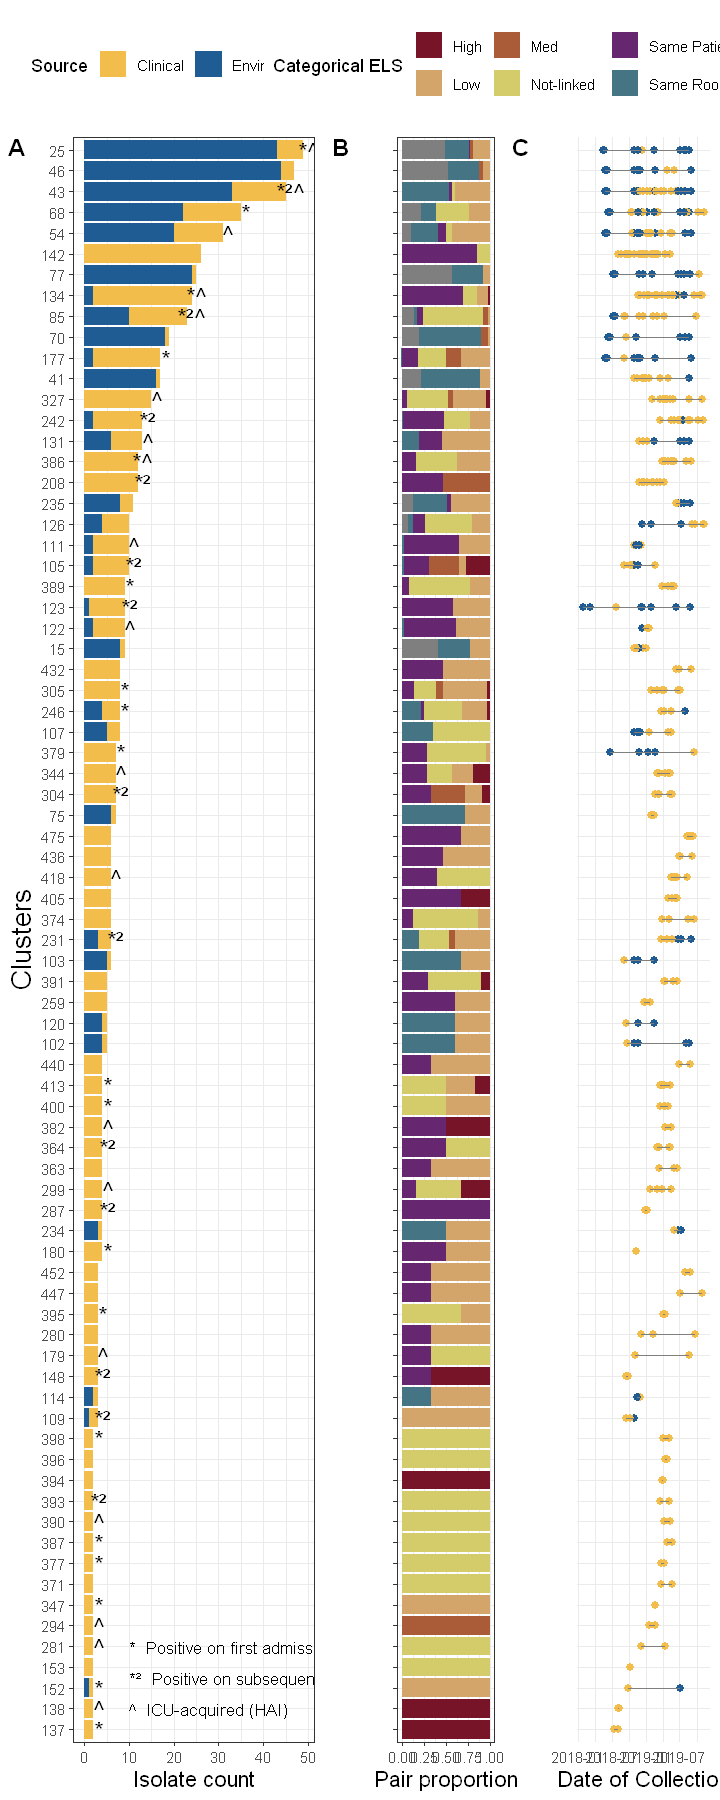

In [24]:
fig <- plot_grid(source_plot+theme(
        legend.position = 'none',
    axis.text.x = element_text(size=9),
axis.text.y = element_text(size=9)),
          
          score_prop_plot+theme(axis.text.y = element_blank(),
     axis.title.y = element_blank(),
        legend.position = 'none',
        axis.text.x = element_text(size=9)),
    line_plot+theme(axis.text.x = element_text(size=9),
                    axis.text.y = element_blank(),
     axis.title.y = element_blank(),
                   legend.position = 'none'),        
          nrow=1,
          align = 'hv', axis = 'tb', rel_widths = c(0.9,0.5,0.6),labels = 'AUTO')
leg <- plot_grid(source_legend,score_legend, nrow=1)
plot_grid(leg , fig,nrow=2, rel_heights = c(0.1,1.3))
ggsave('../output/Figure6.png', device = 'png', dpi = 450, width = 9, height = 9, bg = "white")

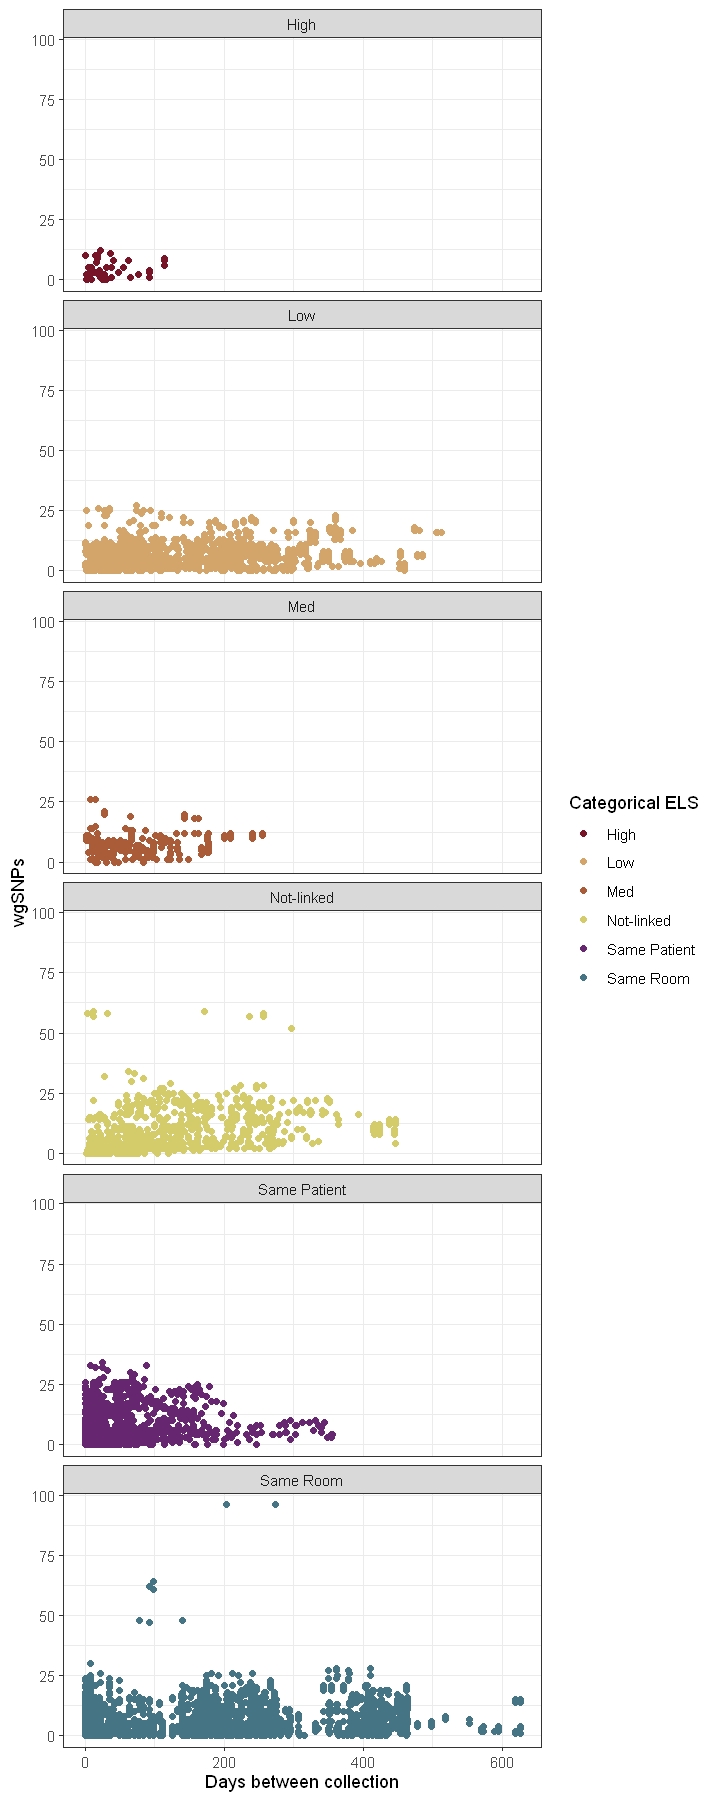

In [27]:
### Fig S6 ###

epi_clusters %>% filter(average24.x == average24.y) %>%
filter(!is.na(score_cat)) %>%
mutate(score_cat = case_when(score_cat == 'same_room_env' ~ 'Same Room',
                            TRUE ~ score_cat)) %>% 
mutate(score_cat = case_when(score_cat == 'Same_Patient' ~ 'Same Patient',
                            TRUE ~ score_cat))%>%
ggplot()+
aes(x=abs(diff_days), y=wg_snps, color=score_cat)+
geom_point()+
facet_wrap(~score_cat, ncol=1)+
theme_bw()+
scale_color_manual(values = score_cat_colors, name='Categorical ELS')+
labs(y = 'wgSNPs',x='Days between collection')

ggsave('../output/S6.png', dpi = 350, device = 'png', width = 8,height = 12)

In [3]:

df2 <- read.csv('../data/sunburst_data.csv')[,-1]

In [4]:
library(dplyr)

# STEP 1: Get cluster-wise info on source types
cluster_summary <- df2 %>%
  group_by(Cluster) %>%
  summarise(
    has_environmental = any(Source == "Environmental"),
    has_clinical = any(Source == "Clinical"),
    only_clinical = all(Source == "Clinical"),
    n_patients = n_distinct(Patient_ID[Source == "Clinical" & !is.na(Patient_ID)]),
    n_admissions = n_distinct(PTCOEX_suffix[Source == "Clinical" & !is.na(PTCOEX_suffix)]),
    n_ptcoex_base = n_distinct(PTCOEX_base[Source == "Clinical" & !is.na(PTCOEX_base)]),
    .groups = "drop"
  )

# STEP 2: Count how many clusters meet each condition

# 1. Clusters with both Environmental and Clinical samples
n_mixed_clusters <- cluster_summary %>%
  filter(has_environmental & has_clinical) %>%
  nrow()

# 2a. Clusters with only Clinical samples from different patients
n_only_clinical_diff_patients <- cluster_summary %>%
  filter(only_clinical & n_patients > 1) %>%
  nrow()

# 2b. Clusters with only Clinical samples from same patient but different admissions
n_only_clinical_same_patient_diff_admissions <- cluster_summary %>%
  filter(
    only_clinical,
    n_ptcoex_base == 1,              # one patient
    n_admissions > 1                # multiple admissions
  ) %>%
  nrow()

# Display results
cat("Clusters with both environmental and clinical samples:", n_mixed_clusters, "\n")
cat("Clusters with only clinical samples from different patients:", n_only_clinical_diff_patients, "\n")
cat("Clusters with only clinical samples from same patient but different admissions:", n_only_clinical_same_patient_diff_admissions, "\n")



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




ERROR: [1m[33mError[39m in `summarise()`:[22m
[1m[22m[36mℹ[39m In argument: `n_patients = n_distinct(Patient_ID[Source == "Clinical" & !is.na(Patient_ID)])`.
[36mℹ[39m In group 1: `Cluster = 1`.
[1mCaused by error:[22m
[33m![39m objeto 'Patient_ID' no encontrado
